<span style="color:red"> **NOTE THAT!** </span>

<font size="5">
While a lattice with dimensions 6x5 and PN=2 leads to a robust charge, a smaller lattice with dimensions 4x4 and PN=3 results in a non-logical charge.
</font>


In [22]:
using BenchmarkTools
using DataFrames
using LaTeXStrings
using Plots
using SparseArrays
using Base.Threads

# Including 

In [23]:
using NBInclude
@nbinclude(joinpath("../Braiding Utils.ipynb"));

<font size="5">
Single Particle Operator
</font>

In [24]:
# executeme
@nbinclude("Kagome SP.ipynb");

<font size="5">
    First Band Approximation Functions
</font>

In [30]:
# executeme
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Model Parameters

<font size="5">
    Lattice Size
</font>

In [31]:
Nx = 5; Ny = 5; N=Nx*Ny*3; Sp_degeneracy = Nx*Ny; cut_off = Sp_degeneracy;

<font size="5">
    Total Particle Number
</font>

In [32]:
PN = [0,1,2,3];
#filtered particle number
pn = maximum(PN);

<font size="5">
    Lattice Potantiel
</font>

In [33]:
U = 2;

<font size="5">
    Hopping Parameters
</font>

In [34]:
t1 = -1; L1 = 0.28; t2 = 0.3; L2 = 0.2;

# Single Particle Sub-Space

<font size="5">
    Single Particle Basis and Operator
</font>

In [35]:
sp_basis = NLevelBasis(N);

In [36]:
sp_matrix = dense(get_SP_H(Nx, Ny, t1, L1, t2, L2)).data;

In [37]:
#H1 = get_sp_op_data(sp_basis, N, sp_matrix);
H1 = get_sp_op(sp_basis, sp_matrix);

<font size="5">
    Eigen Energies
</font>

In [38]:
using LinearAlgebra
#check operator form
eigenenergies(dense(H1)) == eigvals(sp_matrix) # true
eigvals(sp_matrix)

75-element Vector{Float64}:
 -2.800000000000002
 -2.7744324097331194
 -2.774432409733116
 -2.7744324097331154
 -2.7744324097331146
 -2.7744324097331146
 -2.7744324097331092
 -2.7660434339947937
 -2.7660434339947906
 -2.7660434339947892
 -2.7660434339947892
 -2.7660434339947857
 -2.766043433994779
  ⋮
  2.649377845340295
  2.649377845340295
  2.649377845340295
  2.6493778453402954
  2.6493778453402963
  2.649377845340297
  3.0613652383918906
  3.061365238391891
  3.061365238391891
  3.061365238391893
  3.061365238391893
  3.0613652383918937

<font size="4">
    \begin{equation}
    \text{In the kagome lattice:} \quad N_{\phi}=N_xN_y
    \end{equation}
</font>

<font size="5">
    Sub-Space States, Basis Single Particle Operator and Number Operator
</font>

In [39]:
sub_states = get_sub_states(H1, cut_off);
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);
H1_sub = get_subspace_op(H1, P, Pt);
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Many-Body Sub-Space 

<font size="5">
    Sub-Space States, Basis Many-Body Operator
</font>

In [40]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);
H1_MB = get_mb_op(basis_mb, H1_sub);

<font size="5">
    Eigen Energies
</font>

In [41]:
# Differ by numerical result
# eigvals(dense(H1_MB).data);
eigenenergies(dense((H1_MB'+H1_MB)/2))

3276-element Vector{Float64}:
 -8.4
 -8.37443240973317
 -8.374432409733137
 -8.374432409733128
 -8.374432409733092
 -8.374432409733082
 -8.374432409733048
 -8.366043433994866
 -8.366043433994822
 -8.366043433994804
 -8.366043433994788
 -8.366043433994776
 -8.366043433994761
  ⋮
 -2.7644244709398493
 -2.7644244709398476
 -2.7644244709398467
 -2.764424470939844
 -2.764424470939843
 -2.757230036036254
 -2.757230036036251
 -2.7572300360362503
 -2.7572300360362494
 -2.757230036036249
 -2.7572300360362467
  0.0

In [42]:
@nbinclude("Kagome MB .ipynb"; regex=r"#.*executeme");
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

In [17]:
# Hofstadter kıyasla cut-off büyük !

In [18]:
# dimension = size(H1_MB)[1]
# At = create_tensor(basis_cut_mb, dimension, cut_off)
# A = destroy_tensor(basis_cut_mb, dimension, cut_off);

In [19]:
# function get_Int_part_optimized(At, A, dimension)
#     @inbounds begin # skip bounds-checking for speed
#         s = zeros(size(H1_MB))
#         for k = 1:cut_off
#             for l = 1:cut_off
#                 for m = 1:cut_off
#                     for n = 1:cut_off
#                         s += At[:,:,k] * At[:,:,l] * A[:,:,m] * A[:,:,n]
#                     end
#                 end
#             end
#         end
#     end
#     return s
# end

In [139]:
# @btime get_Int_part_optimized(At, A, dimension);

In [ ]:
Hubbard_Interaction(P, Pt, basis_cut_mb, cut_off, U);

In [140]:
#@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));
dimension = size(H1_MB)[1]
optimized_Hubbard_Interaction(P, Pt, basis_cut_mb, dimension, cut_off, U);

In [120]:
H_Int == H_Int_op

true

In [118]:
H_Int_op

# Total Hamiltonian with Impurity Potential

In [52]:
# Kinetic part
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data;

In [53]:
Total_H = H1cut + H_Int;

In [54]:
number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub);

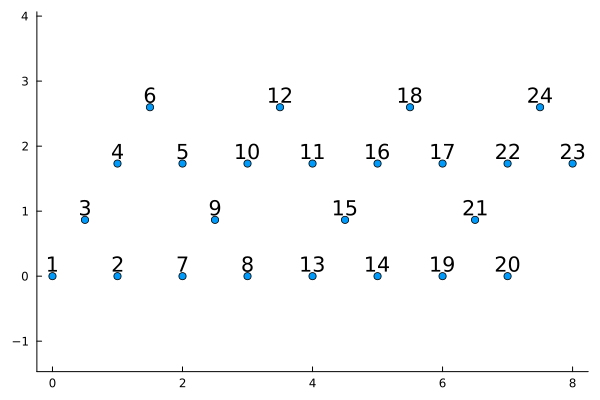

In [55]:
plot_kagome(Nx,Ny)

In [75]:
V0 = [4, 4]; Imp_Site = [9, 22]
Impurity_Data = Impurity(V0, Imp_Site);

In [76]:
Impurity_H = Imp_H(Total_H, number_mb_list_operators, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [77]:
E_Imp, U_Imp = eigenstates(Impurity_H)
E_Imp;

# Exact Diagonalization

<font size="4">
    \begin{align*}
    \text{The number of degeneracy (} \mathscr{D} \text{)} = \frac{(N_d+N-1)!}{N_d!(N-1)!}\frac{N_\phi}{N}
    \end{align*}
<end font>

In [92]:
Hermitian_H = (Impurity_H+dagger(Impurity_H))/2
E, V = eigenstates(dense(Hermitian_H))
filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb)

120-element Vector{Float64}:
 -8.318390558297455
 -8.312017619426857
 -8.204094992469162
 -8.185445680028069
 -8.181120169386146
 -8.178393230958461
 -8.177331529611969
 -8.162952843103643
 -8.125362226728583
 -8.115142818556862
 -8.10632128607177
 -8.101756608713979
 -8.069095359524232
  ⋮
 -5.173683769959641
 -5.169542542797115
 -5.1475408892737295
 -5.143791377708549
 -4.903942760277885
 -4.90343206952614
 -4.702237682656381
 -4.701882453497403
 -3.9668410319058323
 -3.9425124109880993
 -3.2540880299639383
 -3.2539463032628175

In [79]:
r_hubbard_states = Restricted_Hubbard_States(V);

# Densities

<font size="4">
    \begin{align*}
    \frac{N}{N_{\Phi}} &= \frac{2}{8}, \quad \text{In the Laughlin State: } \frac{N}{N_{\Phi}}=\frac{2}{4}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles.}
    \end{align*}
</font>

In [80]:
Degeneracy = 7 

7

In [81]:
avg_density = Get_Avg_Density_List(Nx, Ny, Degeneracy, N, number_mb_list_operators, basis_cut_mb, r_hubbard_states)

24-element Vector{Float64}:
 0.1471259963094075
 0.17218661827091716
 0.15235538166497803
 0.14913040038114916
 0.10825145084760458
 0.14151536183911476
 0.10758298762682302
 0.10881847896336601
 0.0014464214257345483
 0.10682969009233664
 0.1661477843931647
 0.13860942818538352
 0.1523553816650199
 0.17218661827092935
 0.14712599630943335
 0.1415153618391433
 0.10825145084759609
 0.14913040038113193
 0.13860942818539584
 0.1661477843931319
 0.10682969009231476
 0.0014464214257340175
 0.10881847896334937
 0.1075829876268387

# Lattice and Minimum Distances

In [82]:
# Lattice coordinates
c = get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[1]
coordinates = hcat(first.(c), last.(c));

In [83]:
# Ghost Sites
coordinates_top_left = (coordinates.-(Nx*a1_vec)).+(Ny*a2_vec)
coordinates_top = coordinates.+(Ny*a2_vec)
coordinates_top_right = (coordinates.+(Nx*a1_vec)).+(Ny*a2_vec)
coordinates_left = coordinates.-(Nx*a1_vec)
coordinates_right = coordinates.+(Nx*a1_vec)
coordinates_bottom_left = (coordinates.-(Nx*a1_vec)).-(Ny*a2_vec)
coordinates_bottom = coordinates.-(Ny*a2_vec)
coordinates_bottom_right = (coordinates.+(Nx*a1_vec)).-(Ny*a2_vec)
co_districts = [coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates_right,coordinates,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right];

In [84]:
# Distance Functions
function find_co(coordinates, p) # coordinates: Distrincts of Periodic Site
    x_co = coordinates[:,1]
    y_co = coordinates[:,2]
    x = hcat(x_co, y_co)[p, 1]
    y = hcat(x_co, y_co)[p, 2]
    return x, y
end

function distance(coordinates_p1, p1, coordinates_p2, p2)
    x2 = find_co(coordinates_p2, p2)[1]
    x1 = find_co(coordinates_p1, p1)[1]
    y2 = find_co(coordinates_p2, p2)[2]
    y1 = find_co(coordinates_p1, p1)[2]
    return sqrt( (x2 - x1)^2 + (y2 - y1)^2 )
end

distance (generic function with 1 method)

In [85]:
# Example of Disctance Function
coordinates_p1=coordinates
p1 = 1
coordinates_p2=coordinates
p2 = 5
distance(coordinates_p1, p1, coordinates_p2, p2)

2.6457513110645907

# Minimum Distances of Equivalent Sites from Center Reference Site

In [86]:
ref_coordinates = coordinates
ref_site = Imp_Site[1] # Site That Pinned (SADECE 1 PİN OLMALI!!!!)
distances = []
for site_idx in 1:N 
    push!(distances, distance(coordinates, site_idx, ref_coordinates, ref_site))
end
radius_list = sort(unique(distances));

# Density Plot and $Q_{\rho}$ Calculation with Equivalent Sites Conditions

In [87]:
# Find x and y coordinates from given site index

function exp_list0(site_indx)
    
    x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:N)
    y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:N)
    
    x = hcat(x_co, y_co)[site_indx, 1]
    y = hcat(x_co, y_co)[site_indx, 2] 
    
    #!!! 
    # Burada beklenen değerlerin sıralamasının site bazında olduğunu varsaydım!!!!
    #!!!
    exp_val = real(avg_density)[site_indx] 
    
    return x, y, exp_val
end
exp_list0(2)

(1.0, 0.0, 0.17218661827091716)

In [88]:
# Find site_index from given x and y coordinates

function exp_list1(Xx, Yy)
    co_list = hcat(x_co, y_co)
    site_indx = intersect(findall(x->x==Xx, co_list[:,1]), findall(x->x==Yy, co_list[:,2]))
    return real(avg_density)[site_indx] 
end

x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:N)
y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:N)
# site_index = 2
# Xx = x_co[site_index]
# Yy = y_co[site_index]
# print(site_index," => ",Xx,"\t",Yy," => ",exp_list1(Xx, Yy))

24-element OffsetArray(::Vector{Any}, 1:24) with eltype Any with indices 1:24:
 0.0
 0.0
 0.8660254037844386
 1.7320508075688772
 1.7320508075688772
 2.598076211353316
 0.0
 0.0
 0.8660254037844386
 1.7320508075688772
 1.7320508075688772
 2.598076211353316
 0.0
 0.0
 0.8660254037844386
 1.7320508075688772
 1.7320508075688772
 2.598076211353316
 0.0
 0.0
 0.8660254037844386
 1.7320508075688772
 1.7320508075688772
 2.598076211353316

In [89]:
z = exp_list1.(x_co, y_co)
z = collect(Iterators.flatten(z));

In [90]:
z[ref_site]

0.0014464214257345483

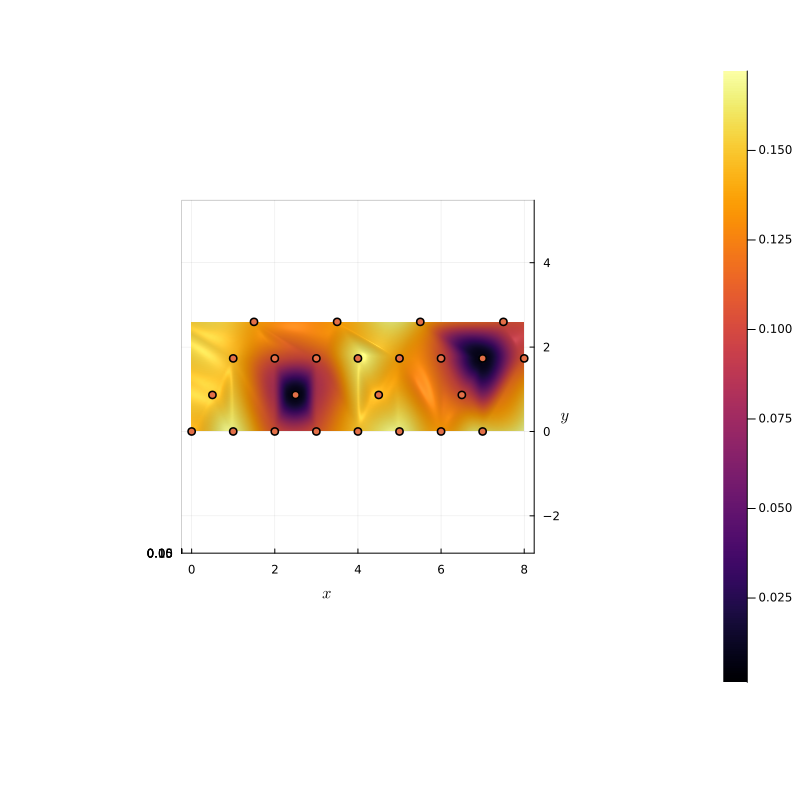

In [91]:
density = exp_list1.(x_co, y_co)
density = collect(Iterators.flatten(z))
surface(x_co,y_co,z,xlabel=L"$x$",ylabel=L"$y$", camera = (0,90), size=(800,800), aspect_ratio=:equal)

# Plot kagome as project to the plot of density profile
scatter!(x_co, y_co, 0. *density, camera=(0,90), legend=false)

In [93]:
# Stack center of coordinates into a array
All_Coordinates = vcat(coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates,coordinates_right,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right)
X_Coordinates = All_Coordinates[:,1]
Y_Coordinates =  All_Coordinates[:,2];

In [94]:
# Index and Coordinates of All Sites
all_idx = []
# There is number of 9 distrinct
for i in 1:9 
    for j in 1:N
        push!(all_idx, j)
    end
end

# All_Coordinates_2, her bir N'lik adet satır, sırasıyla bölge koordinatlarını soldan sağa ve aşağıdan yukarıya gösterir.
# Her bir bölgede 1'den N'e site indekslemesi tüm siteler için yapılır.
All_Coordinates_2 = hcat(all_idx,All_Coordinates);

In [95]:
# using Plots
# center_x = coordinates[N,1]/2
# center_y = coordinates[N,2]/2
# scatter([coordinates_top_left[:,1]],[coordinates_top_left[:,2]],legend=false, alpha=0.3)
# scatter!([coordinates_top[:,1]],[coordinates_top[:,2]], alpha=0.3)
# scatter!([coordinates_top_right[:,1]],[coordinates_top_right[:,2]], alpha=0.3)
# scatter!([coordinates_left[:,1]],[coordinates_left[:,2]], alpha=0.3)
# scatter!([coordinates[:,1]], [coordinates[:,2]],series_annotations = text.(1:N, :bottom))
# scatter!([coordinates_right[:,1]],[coordinates_right[:,2]], alpha=0.3)
# scatter!([coordinates_bottom_left[:,1]],[coordinates_bottom_left[:,2]], alpha=0.3)
# scatter!([coordinates_bottom[:,1]],[coordinates_bottom[:,2]], alpha=0.3)
# scatter!([coordinates_bottom_right[:,1]],[coordinates_bottom_right[:,2]], alpha=0.3)

In [96]:
# Example of Find Equivalent Site 
XX = 9.5 # 0 -> coordinates (X Coordinates of Center Distrinct Site)
YY = 6.06217782649107 # 0 -> coordinates (Y Coordinates of Center Distrinct Site)
# Önce verilen koordinat All_Coordinates_2'de hangi satırda olduğu belirlenir.
Intersect = intersect(findall(x->x==XX, All_Coordinates[:,1]), findall(x->x==YY, All_Coordinates[:,2]))
# Daha sonra, o sitenin, hangi merkez siteye karşılık geldiği tespit edilir.
Equivalent_Site = All_Coordinates_2[:,1][Intersect][1]

24

In [97]:
function Get_Site_Idx(XX, YY)
    Intersect = intersect(findall(x->x==XX, All_Coordinates[:,1]), findall(x->x==YY, All_Coordinates[:,2]))
    Equivalent_Site = All_Coordinates_2[:,1][Intersect][1]
    return Equivalent_Site
end
Get_Site_Idx(-3.5, 4.330127018922193)

9

In [99]:
ref_district = coordinates # Referance Distrinc is the Center Distrinct

# Find imp. site coordinates in the center distrinct
Ref_Site_X = ref_district[:,1][ref_site]
Ref_Site_Y = ref_district[:,2][ref_site]

# Hangi siteler, ilgili yarı-çap içerisinde şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    inner_sites = []
    
    for i in 1:N*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "Get_Site_Idx" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, Get_Site_Idx(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Radius = 1
Inner_Sites(Radius)

5-element Vector{Any}:
  5
  7
  8
  9
 10

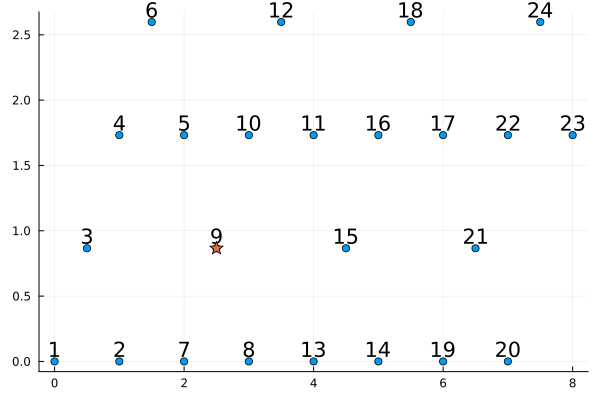

In [101]:
scatter(x_co,y_co,legend=false,series_annotations = text.(1:N, :bottom))
x_imp = exp_list0(ref_site)[1];y_imp=exp_list0(ref_site)[2]
scatter!([x_imp], [y_imp],markershape=:star5,markersize=7)

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\ \\
&\text{In Hofstadter model:}\\
&N_x=8, N_y=10, N=3, \mathcal{D}=7 \\ \\
&<n_i>_{V=0} \approx \frac{N}{N_y(N_{\Phi}-1)} = \frac{N}{N_y(N_x-1)} = \frac{3}{70} \\ \\
&Q_{\rho} \approx \frac{N}{N_{\Phi}-1} = \frac{N}{N_x-1} = \frac{3}{7} \\ \\
&\text{In kagome lattice:} \\
&N_x=4, N_y=2, N=3, \mathcal{D}=7 \\ \\
&<n_i>_{V=0} \approx \frac{N}{3(N_{\Phi}-1)} = \frac{N}{3(N_xN_y-1)} =  \frac{3}{21} \\
 &Q_{\rho} \approx \frac{N}{N_{\Phi}-1} = \frac{N}{N_xN_y-1} =  \frac{3}{7} \\ \\
\end{align*}

In [102]:
#fonksiyonlaştır the ref. partc. den. 

In [103]:
density_list = []
density_list_2 = []
summ_list = []

for i in radius_list
    
    summ = 0

    for j in Inner_Sites(i)
        
        # r içindeki her bir sitenin ortalama yoğunluğu 
        push!(density_list, collect(Iterators.flatten((2/87 .- avg_density|>transpose)))[j])
        # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
        
        # aynı yoğunluklar gelirse sadece onların birisini tut
        density_list_2 = unique!(density_list)
        
        # her biri biricik ve her bir site için olan yoğunlukları topla
        summ = sum(density_list_2)
    end
    
    # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
    push!(summ_list, summ)
    println("Rho:",round(i,digits=3),"\t","Q_rho:",summ)
end

Rho:0.0	Q_rho:0.022949057928163805
Rho:1.0	Q_rho:-0.20037717110844838
Rho:1.732	Q_rho:-0.658621699326918
Rho:2.0	Q_rho:-1.2382996619335553
Rho:2.646	Q_rho:-1.7231117702836987
Rho:3.464	Q_rho:-2.0926762171513547
Rho:3.606	Q_rho:-2.3305889264500044
Rho:4.0	Q_rho:-2.448275862068963
Rho:4.583	Q_rho:-2.448275862068963
Rho:5.292	Q_rho:-2.448275862068963
Rho:5.568	Q_rho:-2.448275862068963


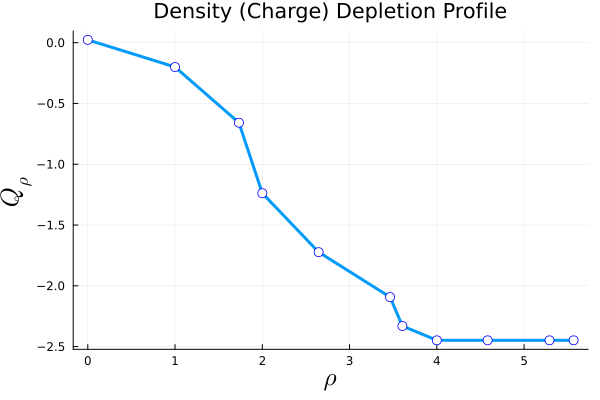

In [104]:
Plots.plot(radius_list, summ_list, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, m = (5, :white, stroke(1, :blue)))
# g(x)=2/87;x=0
# Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

In [47]:
#U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

# MB_Hamiltonian = Kagome_Finite_U(Nx,Ny,Basis_MB,U,sp_op)
# real_space_finite_u = eigenenergies(dense(MB_Hamiltonian)); sub_space_finite_u = E_States[1]
# plot(1:length(real_space_finite_u[1:21]),real_space_finite_u,seriestype=:scatter,markershape=:star5,markersize=7,label="Real-Space")
# plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
# title!("U=$(U)");xlabel!("n");ylabel!("E")